In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import cycle
import pickle
import scipy
import os

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
from collections import Counter

from skmultilearn.model_selection import iterative_train_test_split

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, hamming_loss, confusion_matrix, average_precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# from sklearnex import patch_sklearn
# patch_sklearn()

In [3]:
# Read in the pickle file

with open('../pickled_models/after_eda.pickle', 'rb') as f:
    df_train = pickle.load(f)

df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,word_count,unique_word_count,upper_case_word_count,stop_word_count,punctuation_count,title_word_count,sentence_count,percent_unique_word_count,percent_upper_case_word_count,percent_punctuation_count,cleaned_comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,43,41,2,20,10,11,5,95.348837,4.651163,23.255814,explanation why the edit make under username h...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,17,17,1,3,12,3,4,100.000000,5.882353,70.588235,aww match this background colour seemingly sti...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,42,39,0,21,6,2,4,92.857143,0.000000,14.285714,hey man really not try edit war just that this...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,113,82,5,58,21,7,6,72.566372,4.424779,18.584071,more cannot make any real suggestions improvem...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,13,13,0,6,5,2,3,100.000000,0.000000,38.461538,you sir hero any chance you remember what page...


## Function for modeling

In [4]:
# df_train = df_train.sample(1000)

In [5]:
def gs(feature, pipe, pipe_params, filename, metric):

    X = df_train["cleaned_comment_text"]
    y = df_train[feature]

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, scoring=metric, n_jobs=-1)

    gs.fit(X_train, y_train)

    with open(f"../pickled_models/{metric}/{filename}.pickle", "wb") as f:
        pickle.dump(gs, f)

In [6]:
# Pipeline
tfidf_log_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('lg', LogisticRegression())
])

tfidf_svc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('svc', LinearSVC())
])

tfidf_nb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('nb', ComplementNB())
])

In [7]:
# params
tfidf_log_params = {
    'tfidf__max_features': [2000, 3000, 5000],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'lg__solver': ['liblinear'],
    'lg__C': [0.01, 0.1, 1, 10, 100],
    'lg__penalty': ['l1', 'l2'],
    'lg__max_iter': [1000,2000],
    'lg__class_weight': ['balanced']
}

tfidf_svc_params = {
    'tfidf__max_features': [2000, 3000, 5000],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'svc__C': [0.01,0.1 ,1, 10, 100],
    'svc__max_iter': [10_000],
    'svc__class_weight': ['balanced']
}

tfidf_nb_params = {
    'tfidf__max_features': [2000, 3000, 5000],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'nb__alpha': [0.01, 0.1, 1, 10, 100]
}

# combine

In [8]:
log_models = {
    'toxic': 'toxic_tfidf_log',
    'severe_toxic' : 'severe_toxic_tfidf_log',
    'obscene' : 'obscene_tfidf_log',
    'threat' : 'threat_tfidf_log',
    'insult' : 'insult_tfidf_log',
    'identity_hate' : 'identity_hate_tfidf_log'
}

In [9]:
nb_models = {
    'toxic': 'toxic_tfidf_nb',
    'severe_toxic' : 'severe_toxic_tfidf_nb',
    'obscene' : 'obscene_tfidf_nb',
    'threat' : 'threat_tfidf_nb',
    'insult' : 'insult_tfidf_nb',
    'identity_hate' : 'identity_hate_tfidf_nb'
}

In [12]:
svc_models = {
    'toxic': 'toxic_tfidf_svc',
    'severe_toxic' : 'severe_toxic_tfidf_svc',
    'obscene' : 'obscene_tfidf_svc',
    'threat' : 'threat_tfidf_svc',
    'insult' : 'insult_tfidf_svc',
    'identity_hate' : 'identity_hate_tfidf_svc'
}

In [11]:
for k,v in svc_models.items():
    gs(feature=k, pipe=tfidf_svc_pipe, pipe_params=tfidf_svc_params, filename=v, metric='accuracy')

Process LokyProcess-7:
Traceback (most recent call last):
  File "/home/bryan/miniconda3/envs/cap/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/bryan/miniconda3/envs/cap/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bryan/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 451, in _process_worker
    _process_reference_size = _get_memory_usage(pid, force_gc=True)
  File "/home/bryan/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 117, in _get_memory_usage
    gc.collect()
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
for k,v in log_models.items():
    gs(feature=k, pipe=tfidf_log_pipe, pipe_params=tfidf_log_params, filename=v, metric='accuracy')

In [ ]:
for k,v in nb_models.items():
    gs(feature=k, pipe=tfidf_nb_pipe, pipe_params=tfidf_nb_params, filename=v, metric='accuracy')

In [13]:
# evaulation

# Function to plot confusion matrix and obtain the metrics into a dataframe

def results_extraction(feature="", model_name="", results={}, folder_name="", metric=""):

    '''
    Function to extract the pickle-ed model and to conduct predictions with X_test, saving the final results to a separate dataframe
    '''

    X = df_train["cleaned_comment_text"]
    y = df_train[feature]

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Extract the model
    filename = f'../pickled_models/{metric}/{model_name}.pickle'
    with open(filename, 'rb') as f:
        model = pickle.load(f)

        y_pred = model.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[f'non-{feature}', feature]).plot(cmap='Blues')

    plt.title(f'{model_name}: Confusion Matrix')
    plt.savefig(f"../confusion_matrix/{folder_name}/{metric}/{model_name}_{metric}_confusion_matrix.png", bbox_inches='tight', facecolor='w')
    plt.close()

    # Different metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    misclassification = 1 - accuracy
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f1 = 2 * (precision * recall) / (precision + recall)

    acc_diff = np.abs((model.score(X_train, y_train) - model.score(X_test, y_test))) / model.score(X_train, y_train)

    # Metrics for roc curve and auc
    # LinearSVC does not have predict proba - decision function will be used instead
    if "svc" not in model_name:
        pred_proba = model.predict_proba(X_test)[:,1]
        train_proba = model.predict_proba(X_train)[:,1]


    else:
        pred_proba = model.decision_function(X_test)
        train_proba = model.decision_function(X_train)

    pred_auc_score = roc_auc_score(y_test, pred_proba)
    train_auc_score = roc_auc_score(y_train, train_proba)
    pred_prc_score = average_precision_score(y_test, pred_proba)
    train_prc_score = average_precision_score(y_train, train_proba)
    auc_diff = np.abs((train_auc_score - pred_auc_score)) / train_auc_score
    prc_diff = np.abs((train_prc_score - pred_prc_score)) / train_prc_score


    # Append all above results to 'results' dictionary
    results[model_name] = [
        metric,
        model.best_params_,
        model.score(X_train, y_train),
        model.score(X_test, y_test),
        misclassification,
        recall,
        specificity,
        precision,
        f1,
        train_auc_score,
        pred_auc_score,
        train_prc_score,
        pred_prc_score,
        auc_diff,
        prc_diff,
        acc_diff
    ]

In [14]:
results_log_acc = {}
for k,v in log_models.items():
    results_extraction(feature=k, model_name=v, results=results_log_acc, folder_name="logistic_regression", metric='accuracy')

results_nb_acc = {}
for k,v in nb_models.items():
    results_extraction(feature=k, model_name=v, results=results_nb_acc, folder_name="naive_bayes", metric='accuracy')

results_svc_acc = {}
for k,v in svc_models.items():
    results_extraction(feature=k, model_name=v, results=results_svc_acc, folder_name="linear_svc", metric='accuracy')

In [17]:
# Create a dataframe for all results

def all_data(results_list=[], results_dict={}):
    '''
    Function to create a dataframe for all results
    '''
    for r in results_list:
            # pd.DataFrame()
        for k,v in r.items():
            results_dict[k] = v
        
    df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['metric','best_params', 'train_acc_score', 'test_acc_score', 'misclassification', 'recall', 'specificity', 'precision', 'f1', 'train_auc', 'pred_auc', 'train_prc', 'pred_prc', 'auc_diff', 'prc_diff', 'acc_diff'])
    
    return df

# Gridsearch with different metrics

As the dataset is imbalanced, and we want to predict the minority class. Normally we would use the F1 score as the metric. However, we want to see how the model performs on the 

In [90]:
for k,v in log_models.items():
    gs(feature=k, pipe=tfidf_log_pipe, pipe_params=tfidf_log_params, filename=v, metric='average_precision')

/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [42]:
for k,v in nb_models.items():
    gs(feature=k, pipe=tfidf_nb_pipe, pipe_params=tfidf_nb_params, filename=v, metric='average_precision')

In [43]:
for k,v in svc_models.items():
    gs(feature=k, pipe=tfidf_svc_pipe, pipe_params=tfidf_svc_params, filename=v, metric='average_precision')

/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to 

In [15]:
results_log_prc = {}
for k,v in log_models.items():
    results_extraction(feature=k, model_name=v, results=results_log_prc, folder_name="logistic_regression", metric='average_precision')

results_nb_prc = {}
for k,v in nb_models.items():
    results_extraction(feature=k, model_name=v, results=results_nb_prc, folder_name="naive_bayes", metric='average_precision')

results_svc_prc = {}
for k,v in svc_models.items():
    results_extraction(feature=k, model_name=v, results=results_svc_prc, folder_name="linear_svc", metric='average_precision')

In [18]:
results_list_acc = [
    results_log_acc,
    results_nb_acc,
    results_svc_acc,
]

results_list_prc = [
    results_log_prc,
    results_nb_prc,
    results_svc_prc,
]

acc_final_results = all_data(results_list=results_list_acc, results_dict={})
prc_final_results = all_data(results_list=results_list_prc, results_dict={})

In [24]:
final_results = pd.concat([acc_final_results.reset_index(), prc_final_results.reset_index()], axis=0, ignore_index=True)
final_results.head()

,index,metric,best_params,train_acc_score,test_acc_score,misclassification,recall,specificity,precision,f1,train_auc,pred_auc,train_prc,pred_prc,auc_diff,prc_diff,acc_diff
0,toxic_tfidf_log,accuracy,"{'lg__C': 0.01, 'lg__class_weight': 'balanced'...",0.936741,0.936497,0.063503,0.623147,0.969712,0.685612,0.652889,0.892947,0.889222,0.699938,0.697111,0.004172,0.004039,0.000260
1,severe_toxic_tfidf_log,accuracy,"{'lg__C': 10, 'lg__class_weight': 'balanced', ...",0.975667,0.969962,0.030038,0.828810,0.971388,0.226469,0.355735,0.994854,0.973030,0.549261,0.406304,0.021937,0.260272,0.005847
2,obscene_tfidf_log,accuracy,"{'lg__C': 0.01, 'lg__class_weight': 'balanced'...",0.975882,0.976479,0.023521,0.773964,0.987802,0.780119,0.777030,0.955473,0.954688,0.817800,0.814554,0.000822,0.003969,0.000612
3,threat_tfidf_log,accuracy,"{'lg__C': 100, 'lg__class_weight': 'balanced',...",0.999472,0.993650,0.006350,0.419580,0.995370,0.213523,0.283019,0.999942,0.949330,0.963691,0.202867,0.050615,0.789489,0.005825
4,insult_tfidf_log,accuracy,"{'lg__C': 0.01, 'lg__class_weight': 'balanced'...",0.962292,0.960833,0.039167,0.734236,0.972599,0.581824,0.649205,0.936402,0.931655,0.650390,0.635588,0.005070,0.022758,0.001516


In [22]:
with open('../pickled_models/final_split_results.pickle', 'wb') as f:
    pickle.dump(final_results, f)

# Precision Recall Curve

In [155]:
# Function to plot the prc and auc curves


def plot_prc(models_list, metrics, model_type):
    '''
    Function to plot the prc curves for all features
    '''
    # setup plot details
    colors = cycle(sns.color_palette("Set2", 10))

    _, ax = plt.subplots(figsize=(7, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    for k, v in models_list.items():
        X = df_train["cleaned_comment_text"]
        y = df_train[k]

        # train test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        filename = f"../pickled_models/{metrics}/{k}_tfidf_{model_type}.pickle"
        with open(filename, "rb") as f:
            model = pickle.load(f)
        display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name=k)
        plt.close()
        display.plot(ax=ax, color=next(colors), name=k)

    # add the legend for the iso-f1 curves
    # handles, labels = display.ax_.get_legend_handles_labels()
    # handles.extend([l])
    # labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="best", bbox_to_anchor=(1.05, 1))
    ax.set_title(f"{metrics} - Precision-Recall curve - {model_type}".title())
    plt.savefig(f"../charts/{metrics}_prc_{model_type}.png", bbox_inches="tight")

    plt.show()

In [162]:

def plot_roc(models_list, metrics, model_type):
    '''
    Function to plot roc curve for all features
    '''
    # setup plot details
    colors = cycle(sns.color_palette("Set2", 10))

    _, ax = plt.subplots(figsize=(7, 8))

    for k, v in models_list.items():
        X = df_train["cleaned_comment_text"]
        y = df_train[k]

        # train test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        filename = f"../pickled_models/{metrics}/{k}_tfidf_{model_type}.pickle"
        with open(filename, "rb") as f:
            model = pickle.load(f)
        display = RocCurveDisplay.from_estimator(model, X_test, y_test, name=k)
        plt.close()
        display.plot(ax=ax, color=next(colors), name=k)


    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="best", bbox_to_anchor=(1.05, 1))
    ax.set_title(f"{metrics} - ROC curve - {model_type}".title())
    plt.savefig(f"../charts/{metrics}_roc_{model_type}.png", bbox_inches="tight")

    plt.show()

## Accuracy Plots

In [164]:
dict_models = {
    'log_models' : 'log',
    'nb_models' : 'nb',
    'svc_models' : 'svc'
}

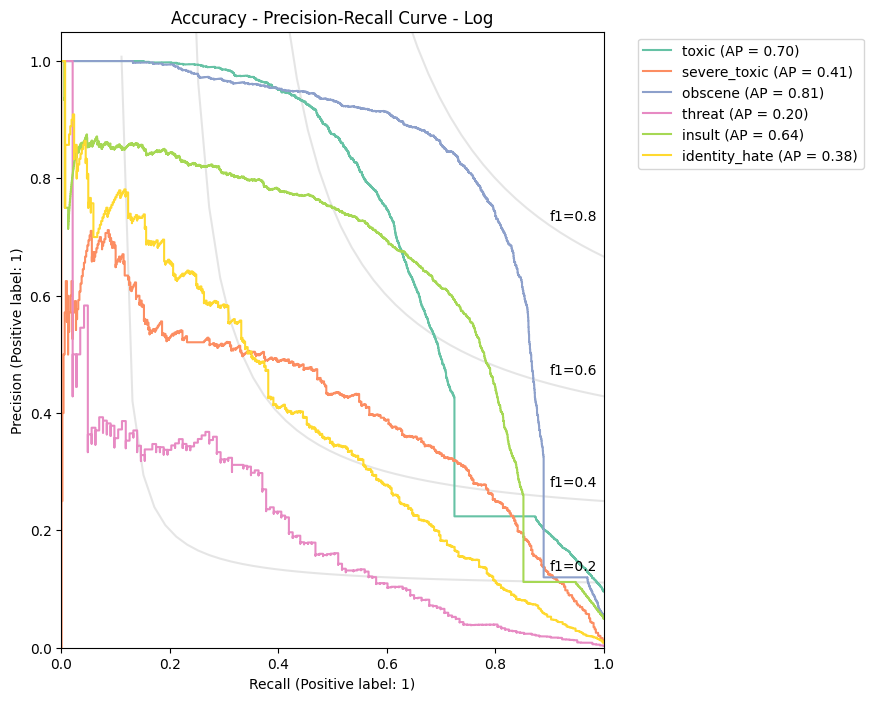

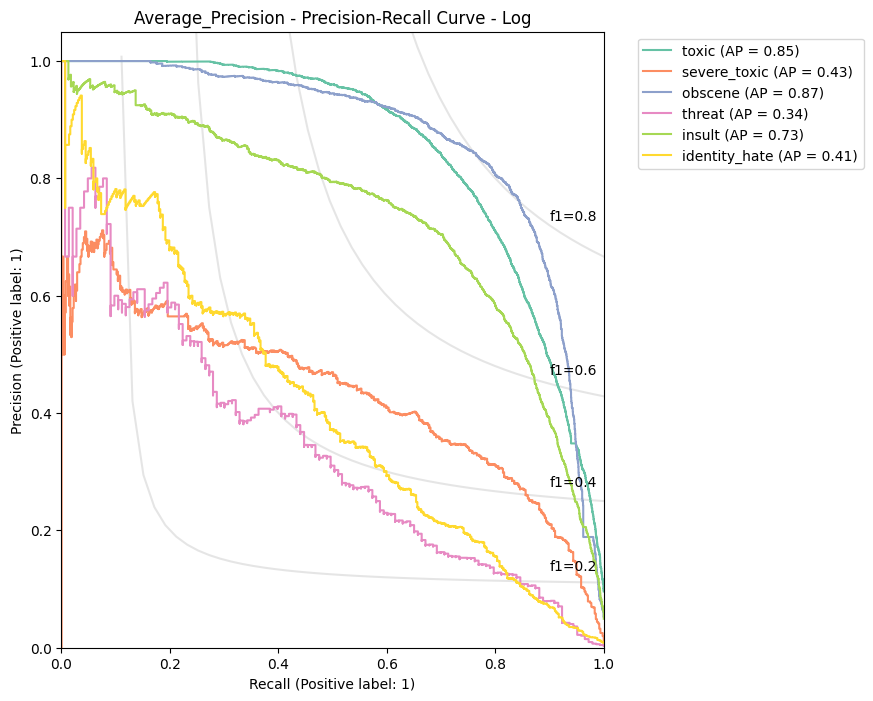

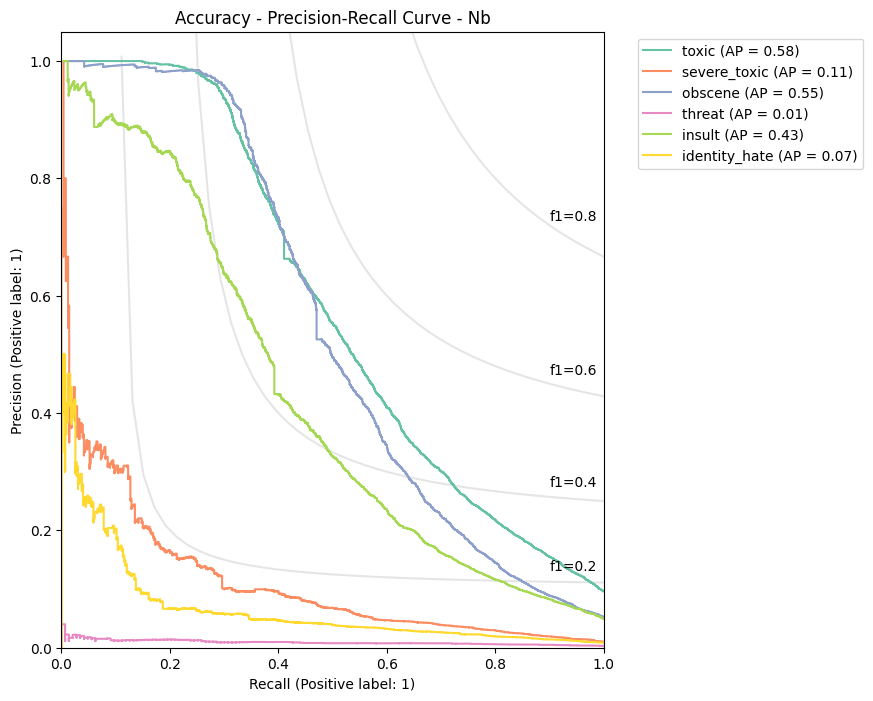

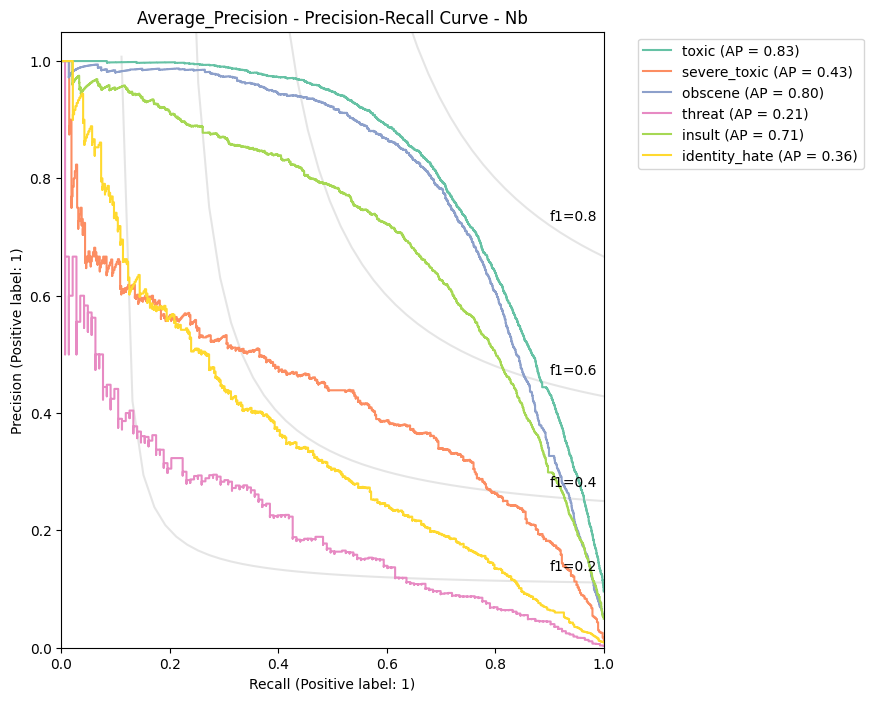

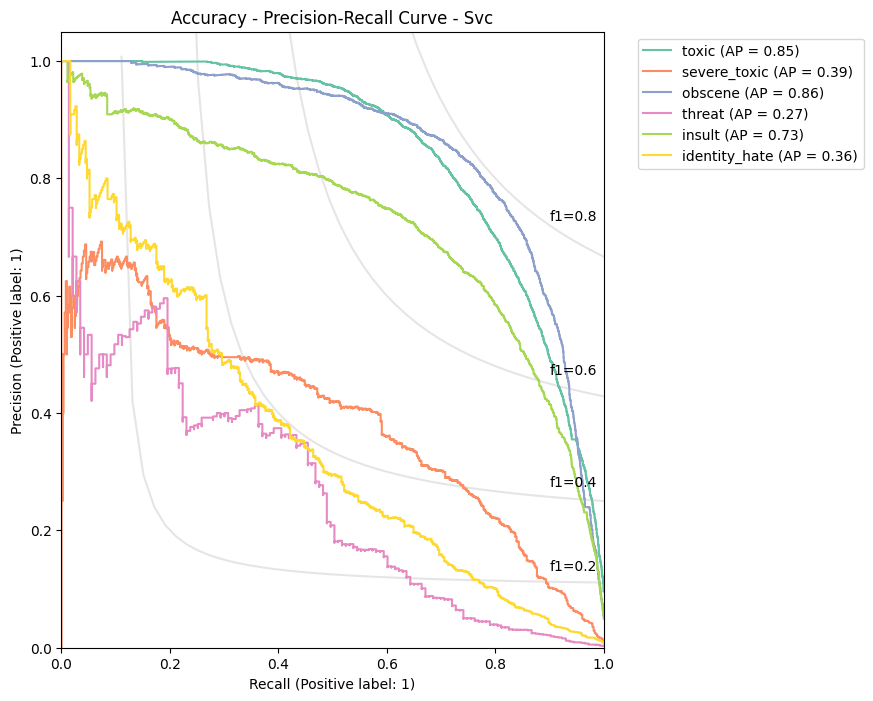

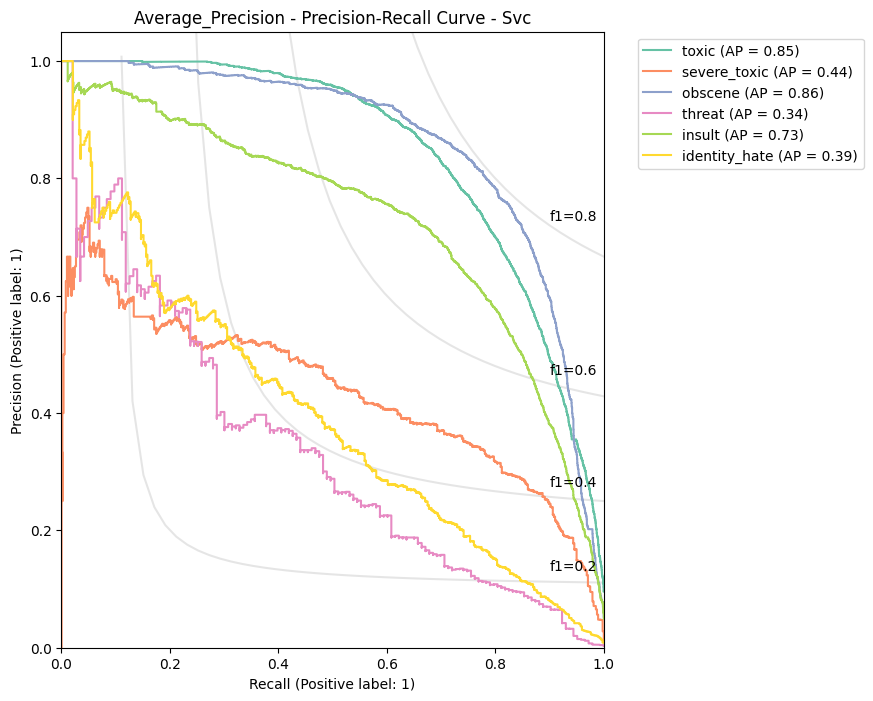

In [166]:
for k,v in dict_models.items():
    plot_prc(models_list=eval(k), metrics='accuracy', model_type=v)
    plot_prc(models_list=eval(k), metrics='average_precision', model_type=v)

In [23]:
final_results.query("index.str.contains('svc')", engine='python')

,index,metric,best_params,train_acc_score,test_acc_score,misclassification,recall,specificity,precision,f1,train_auc,pred_auc,train_prc,pred_prc,auc_diff,prc_diff,acc_diff
12,toxic_tfidf_svc,accuracy,"{'svc__C': 0.1, 'svc__class_weight': 'balanced...",0.937251,0.929416,0.070584,0.863557,0.936397,0.590022,0.701053,0.981246,0.965087,0.883868,0.847406,0.016468,0.041253,0.008360
13,severe_toxic_tfidf_svc,accuracy,"{'svc__C': 1, 'svc__class_weight': 'balanced',...",0.975219,0.969189,0.030811,0.807933,0.970818,0.218644,0.344153,0.994778,0.968517,0.540660,0.391741,0.026399,0.275439,0.006184
14,obscene_tfidf_svc,accuracy,"{'svc__C': 0.01, 'svc__class_weight': 'balance...",0.969543,0.968102,0.031898,0.872978,0.973421,0.647455,0.743491,0.988073,0.979668,0.881077,0.858390,0.008506,0.025750,0.001486
15,threat_tfidf_svc,accuracy,"{'svc__C': 10, 'svc__class_weight': 'balanced'...",0.998451,0.994444,0.005556,0.482517,0.995977,0.264368,0.341584,0.999723,0.948465,0.827201,0.266161,0.051272,0.678239,0.004014
16,insult_tfidf_svc,accuracy,"{'svc__C': 0.01, 'svc__class_weight': 'balance...",0.953983,0.950765,0.049235,0.854422,0.955767,0.500744,0.631431,0.981391,0.972003,0.765100,0.729479,0.009566,0.046557,0.003374
17,identity_hate_tfidf_svc,accuracy,"{'svc__C': 1, 'svc__class_weight': 'balanced',...",0.978299,0.970818,0.029182,0.675355,0.973446,0.184466,0.289781,0.996562,0.940863,0.656579,0.356131,0.055892,0.457597,0.007647
30,toxic_tfidf_svc,average_precision,"{'svc__C': 0.1, 'svc__class_weight': 'balanced...",0.883868,0.847406,0.070584,0.863557,0.936397,0.590022,0.701053,0.981246,0.965087,0.883868,0.847406,0.016468,0.041253,0.041253
31,severe_toxic_tfidf_svc,average_precision,"{'svc__C': 0.01, 'svc__class_weight': 'balance...",0.449019,0.436017,0.035010,0.916493,0.965480,0.211566,0.343774,0.990657,0.985701,0.449019,0.436017,0.005003,0.028956,0.028956
32,obscene_tfidf_svc,average_precision,"{'svc__C': 0.1, 'svc__class_weight': 'balanced...",0.903582,0.861191,0.034007,0.888757,0.970311,0.626007,0.734594,0.992374,0.978720,0.903582,0.861191,0.013758,0.046915,0.046915
33,threat_tfidf_svc,average_precision,"{'svc__C': 0.1, 'svc__class_weight': 'balanced...",0.565727,0.335908,0.013139,0.706294,0.987701,0.146802,0.243081,0.998884,0.970361,0.565727,0.335908,0.028555,0.406237,0.406237


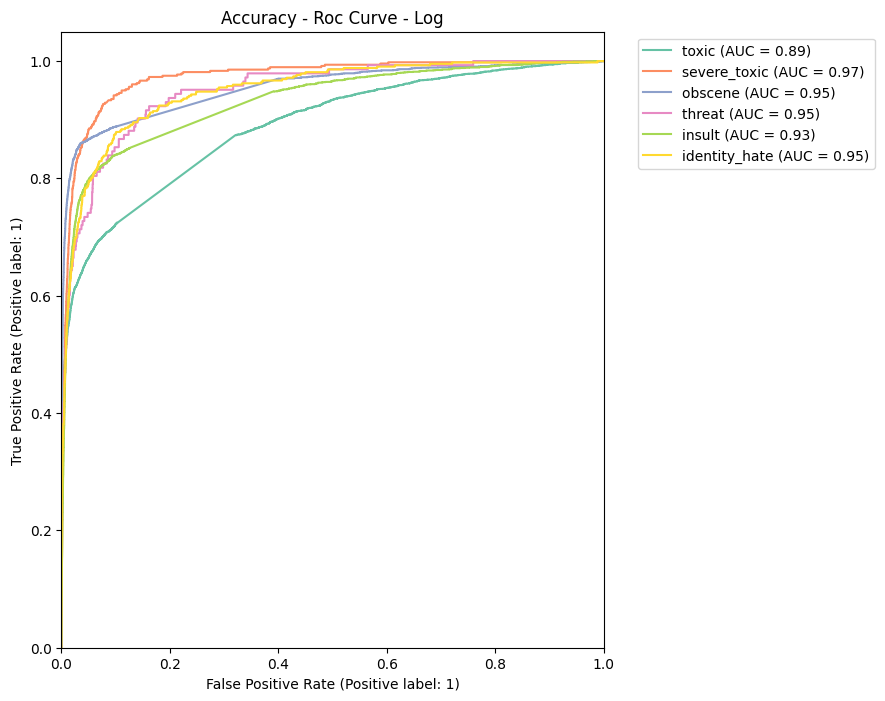

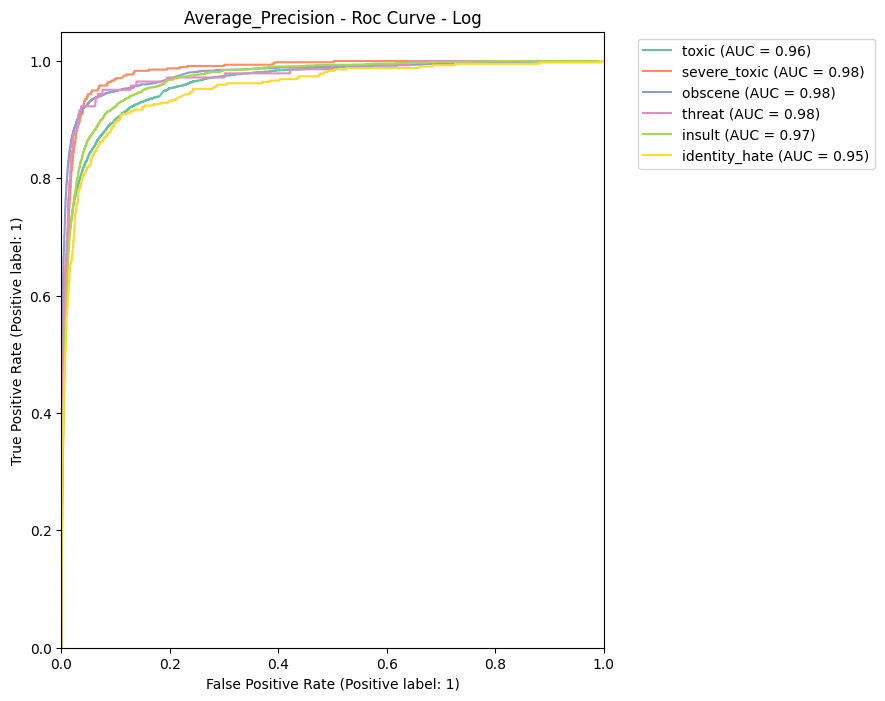

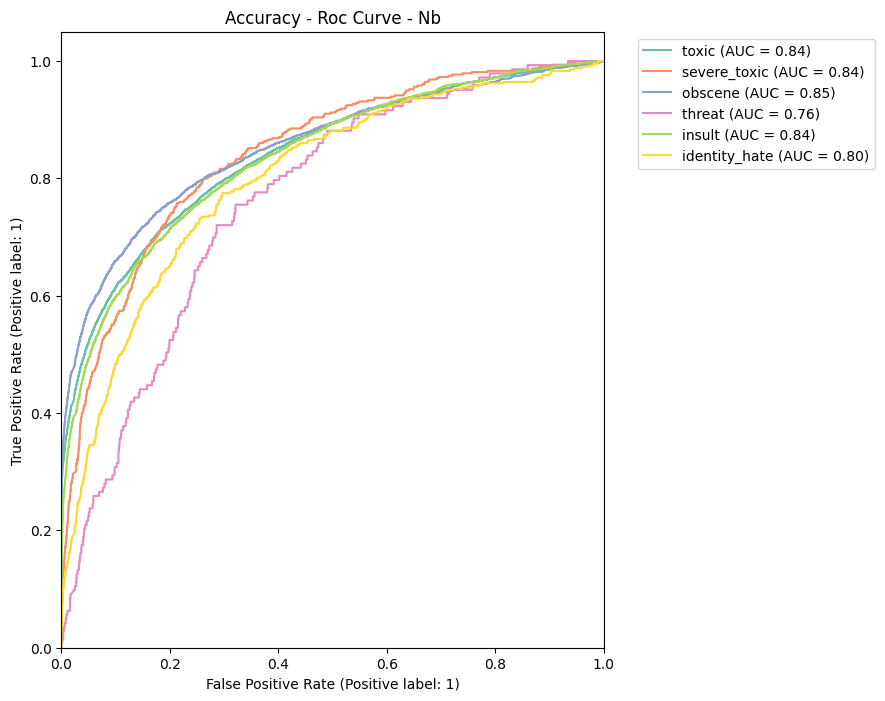

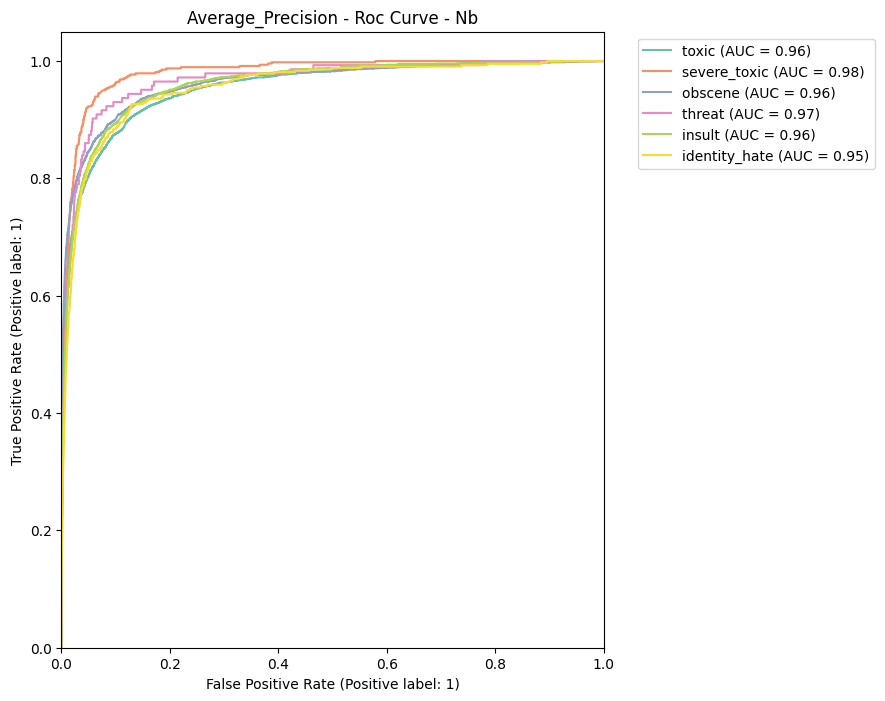

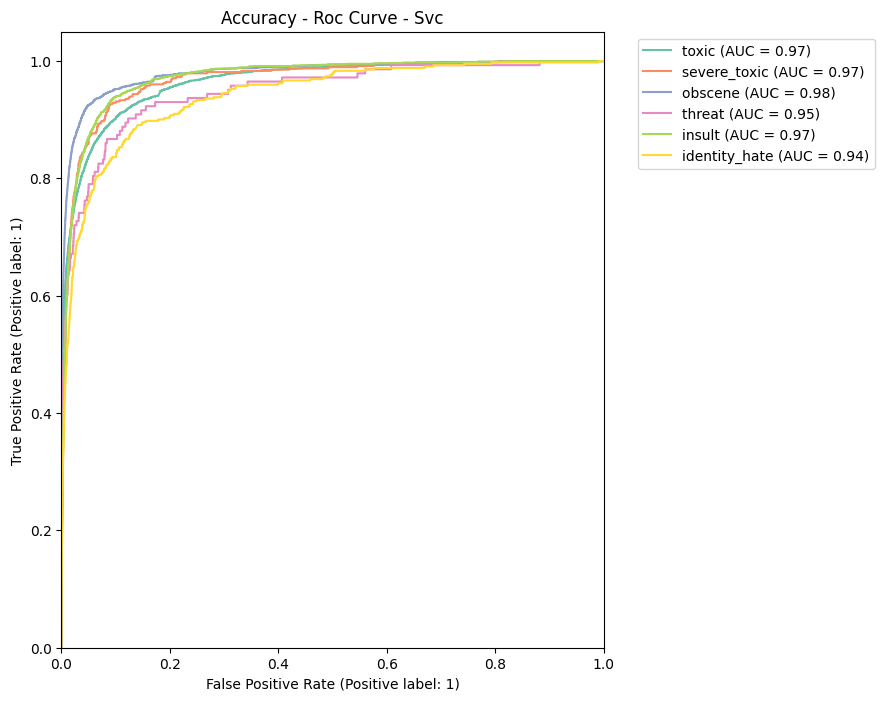

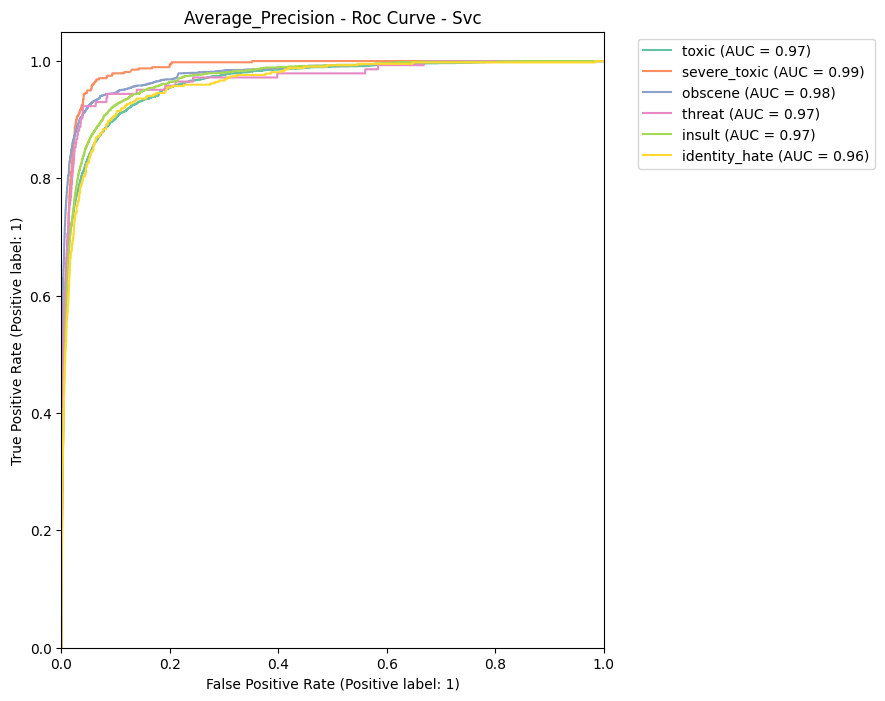

In [167]:
for k,v in dict_models.items():
    plot_roc(models_list=eval(k), metrics='accuracy', model_type=v)
    plot_roc(models_list=eval(k), metrics='average_precision', model_type=v)

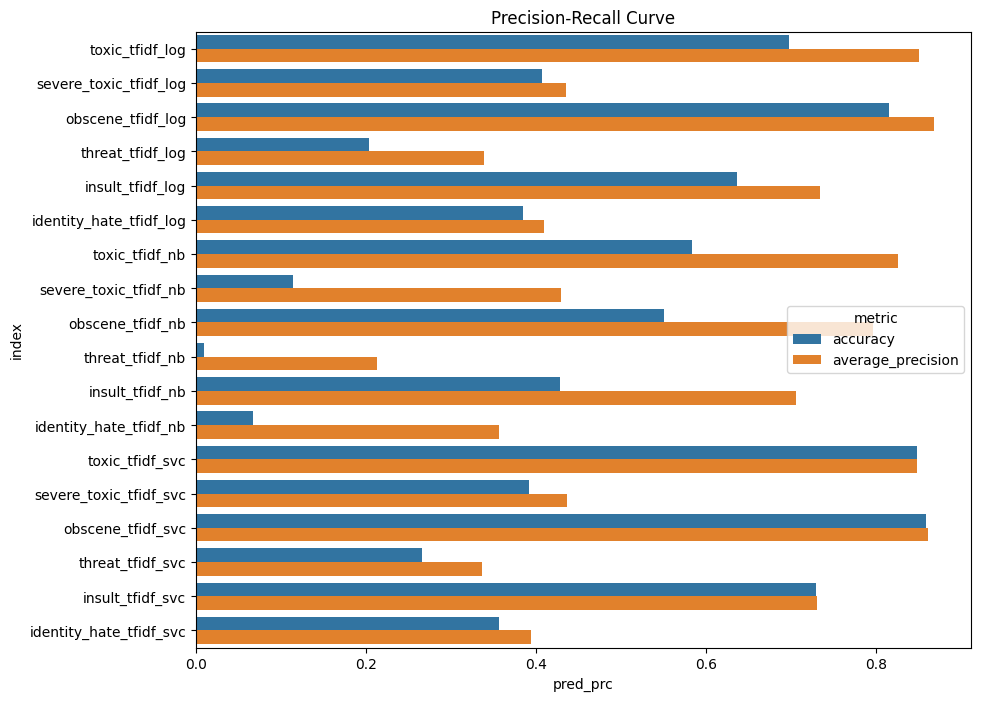

In [194]:
# final_results.query("metric == 'accuracy'")['pred_prc'].plot(kind='bar', figsize=(10,8), title='Accuracy - Precision-Recall Curve')

plt.figure(figsize=(10,8))

sns.barplot(y='index', x='pred_prc', hue='metric', data=final_results)

plt.title('Precision-Recall Curve')
plt.show()